In [2]:
import pandas
import neattext as nt
import numpy as np
import transformers
import pyarrow as pa
import torch
import math

from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from datasets import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup


In [12]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [13]:
# Keeping hashtags as they can be important for the emotion recognition.

def preprocess_data(text):
    text = text.replace("[NAME]", "")
    text = text.replace("[RELIGION]", "")
    docx = nt.TextFrame(text=text)
    text = docx.remove_urls()
    text = docx.remove_dates()
    text = docx.remove_numbers()
    text = docx.remove_html_tags()
    text = docx.remove_emojis()
    text = docx.remove_special_characters()
    return docx.text

In [14]:
# Because BERT is a language model that utilises the structure of the sentence from both directions to connect every output element to every 
# input element, and dynamically adjust weightings depending on this connection (this process is called attention), my hypothesis is that 
# the lighter pre-processing will do better. This is because stopwords and other grammatical features of sentences may have a part to play 
# in helping the model’s attention.

def process_data(rows):
    processed_rows = tokenizer.batch_encode_plus(
        rows,
        add_special_tokens=True,
        max_length = 128,
        padding = 'max_length',
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt'
    )

    input_ids = processed_rows['input_ids']
    attention_masks = processed_rows['attention_mask']
    return input_ids, attention_masks

In [3]:
emotions_dictionary = {'sadness': 0, 'joy': 1, 'anger': 2, 'fear': 3, 'surprise': 4} 
emotions_dictionary_inverted = {0: 'sadness', 1: 'joy', 2: 'anger', 3: 'fear', 4: 'surprise'}

In [7]:
from transformers import AutoModelForSequenceClassification

new_model = AutoModelForSequenceClassification.from_pretrained('model')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [9]:
from collections import defaultdict

conversations = []

def clean_text(text):
  text = text.replace("\ ", '')
  text = text.replace('-', ' ')
  text = text.replace(' / ', '')
  return text


with open('conversations.txt', 'r') as file:
  for line in file.readlines():
    line = line.split('+')
    line = [x for x in line if x != ' \n']
    
    conversation_data = []
    
    for index in range(0, len(line)-1, 2):
      conversation_data.append((line[index], clean_text(line[index+1])))  
    conversations.append(conversation_data)
  file.close()

In [10]:
conversations[0]

[('WILL ',
  '  Did you buy all these books retail, or do you send away for like a "shrink kit" that comes with all these volumes included? '),
 (' SEAN ', '  Have you read all these books, Will? '),
 (' WILL ', '  Probably not. '),
 (' SEAN ', '  How about the ones on that shelf? ')]

In [24]:
from torch.nn.functional import softmax

conversation_emotions = []

for conversation in conversations:
    for character,utterance in conversation:
        utterance_to_predict = preprocess_data(utterance)
        input_ids, att_masks = process_data([utterance_to_predict])
        output = new_model(input_ids = input_ids, attention_mask=att_masks)
        prediction = np.argmax(output.logits.cpu().detach().numpy(),axis=-1)
        confidence = torch.max(softmax(output.logits, dim=1))
        print(utterance)

        if confidence > 0.70:
          emotion = emotions_dictionary_inverted[prediction[0]]
        else:
          emotion = "NETRUAL"
        print(emotion)
        
        conversation_emotions.append((character, emotion))
    


    

  Did you buy all these books retail, or do you send away for like a "shrink kit" that comes with all these volumes included? 
tensor(0.8669, grad_fn=<MaxBackward1>)
  Have you read all these books, Will? 
tensor(0.8717, grad_fn=<MaxBackward1>)
  Probably not. 
tensor(0.6498, grad_fn=<MaxBackward1>)
  How about the ones on that shelf? 
tensor(0.8988, grad_fn=<MaxBackward1>)
  Yeah, I read those. 
tensor(0.7620, grad_fn=<MaxBackward1>)
  What did you think? 
tensor(0.6828, grad_fn=<MaxBackward1>)
  I'm not here for a fuckin' book report. They're your books, why don't you read 'em? 
tensor(0.9350, grad_fn=<MaxBackward1>)
  I did. 
tensor(0.4206, grad_fn=<MaxBackward1>)
  That must have taken you a long time. 
tensor(0.3861, grad_fn=<MaxBackward1>)
  Yeah, it did take me a long time. 
tensor(0.3144, grad_fn=<MaxBackward1>)
  "A History of the United States, Volume I." If you want to read a real history book, read Howard Zinn's "A People's History of the United States." That book will knoc

In [290]:
conversation_emotions

[('WILL ', 'surprise'),
 (' SEAN ', 'surprise'),
 (' WILL ', 'NETRUAL'),
 (' SEAN ', 'surprise'),
 ('WILL ', 'surprise'),
 (' SEAN ', 'NETRUAL'),
 (' WILL ', 'anger'),
 (' SEAN ', 'NETRUAL'),
 (' WILL ', 'NETRUAL'),
 (' SEAN ', 'NETRUAL'),
 ('WILL ', 'anger'),
 (' SEAN ', 'NETRUAL'),
 (' WILL ', 'anger'),
 (' SEAN ', 'surprise'),
 (' WILL ', 'anger'),
 ('SEAN ', 'NETRUAL'),
 (' WILL ', 'NETRUAL'),
 ('SEAN ', 'NETRUAL'),
 (' WILL ', 'surprise'),
 (' SEAN ', 'surprise'),
 (' SEAN ', 'NETRUAL'),
 (' WILL ', 'surprise'),
 ('SEAN ', 'NETRUAL'),
 (' WILL ', 'NETRUAL'),
 (' SEAN ', 'NETRUAL'),
 (' WILL ', 'anger'),
 (' SEAN ', 'NETRUAL'),
 (' WILL ', 'sadness'),
 (' SEAN ', 'NETRUAL'),
 (' WILL ', 'surprise'),
 (' SEAN ', 'NETRUAL'),
 (' WILL ', 'NETRUAL'),
 (' SEAN ', 'surprise'),
 (' WILL ', 'surprise'),
 (' SEAN ', 'NETRUAL'),
 (' WILL ', 'NETRUAL'),
 (' SEAN ', 'surprise'),
 ('SEAN ', 'NETRUAL'),
 (' WILL ', 'anger'),
 (' SEAN ', 'anger'),
 (' WILL ', 'anger'),
 ('SEAN ', 'anger'),
 (' WI

In [302]:
will_emotions = []
sean_emotions = []

for emotion in conversation_emotions:
    if emotion[0] == 'WILL':
        will_emotions.append(emotion[1])
    else:
        sean_emotions.append(emotion[1])
    

df = pandas.DataFrame(conversation_emotions, columns=['character', 'emotion'])  
df

,character,emotion
0,WILL,surprise
1,SEAN,surprise
2,WILL,NETRUAL
3,SEAN,surprise
4,WILL,surprise
...,...,...
173,SEAN,NETRUAL
174,WILL,anger
175,SEAN,anger
176,WILL,joy


In [87]:
will_emotions = (df[df['character'] == ' WILL '])['emotion']

([<matplotlib.patches.Wedge at 0x7f89cc0eaa00>,
 [Text(0.3571693699839605, 1.040398981710988, 'Anger'),
  Text(-0.967421087629068, -0.523542203848545, 'Surprise'),
  Text(0.6756340288727332, -0.868054525377985, 'Joy'),
  Text(1.0849974419956991, -0.18105399985305384, 'Sadness')],
 [Text(0.19481965635488752, 0.5674903536605389, '39.5%'),
  Text(-0.5276842296158551, -0.285568474826479, '36.8%'),
  Text(0.3685276521123999, -0.47348428656980995, '18.4%'),
  Text(0.5918167865431085, -0.0987567271925748, '5.3%')])

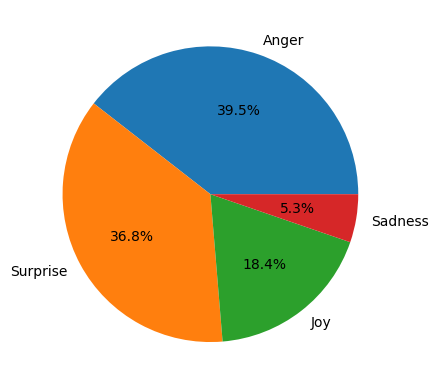

In [288]:
# Grafico emozioni will con SEAN

will_emotions.value_counts().tolist()

import matplotlib.pyplot as plt
labels = 'Anger', 'Surprise', 'Joy', 'Sadness'
sizes = (will_emotions.value_counts().tolist())[1:]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

In [308]:
sean_emotions = (df[df['character'] == ' SEAN '])
sean_emotions = sean_emotions[sean_emotions['emotion'] != 'NETRUAL']
sean_emotions.value_counts().tolist()

[13, 10, 9, 5, 1]

([<matplotlib.patches.Wedge at 0x7f8970721190>,
 [Text(0.5235421132720435, 0.9674211366466224, 'Surprise'),
  Text(-1.0849974462335736, 0.18105397445685545, 'Joy'),
  Text(-0.1810539236644592, -1.0849974547093206, 'Anger'),
  Text(0.9208832150306883, -0.6016428377989249, 'Sadness'),
  Text(1.0962429571347696, -0.0908371010788867, 'Fear')],
 [Text(0.2855684254211146, 0.5276842563527031, '34.2%'),
  Text(-0.5918167888546765, 0.09875671334010296, '26.3%'),
  Text(-0.09875668563515955, -0.5918167934778112, '23.7%'),
  Text(0.5022999354712845, -0.32816882061759534, '13.2%'),
  Text(0.5979507038916925, -0.04954750967939274, '2.6%')])

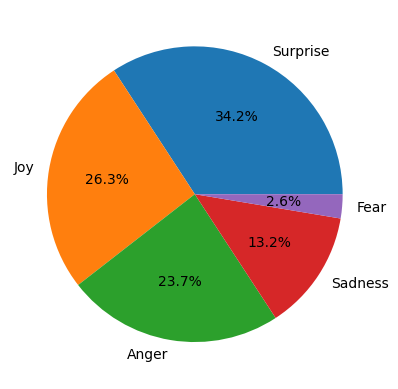

In [310]:
# Grafico emozioni SEAN con WILL

import matplotlib.pyplot as plt
labels = 'Surprise','Joy', 'Anger', 'Sadness', 'Fear'
sizes = sean_emotions.value_counts().tolist()
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')


In [ ]:
# Costruiamo un grafico dove le emozioni di Will vengono divise in 5 sottogruppi (le emozioni sono ordinate cronologicamente).

In [162]:
lists = np.array_split(will_emotions.tolist(), 5) 
indexes = []

for index in range(1, len(lists)+1):
    indexes.append(str(index))
    
list_to_plot = []


for index in range(0, len(lists)):
    for item in lists[index]:
        list_to_plot.append([index+1, item])



second_graph_df = pandas.DataFrame(list_to_plot, columns = ['index', 'emotion']) 
second_graph_df = second_graph_df[second_graph_df['emotion'] != 'NETRUAL']

In [187]:
first = second_graph_df[second_graph_df['index'] == 1].filter(['emotion'])
second = second_graph_df[second_graph_df['index'] == 2].filter(['emotion'])
third = second_graph_df[second_graph_df['index'] == 3].filter(['emotion'])
fourth = second_graph_df[second_graph_df['index'] == 4].filter(['emotion'])
fifth = second_graph_df[second_graph_df['index'] == 5].filter(['emotion'])

In [188]:
first = first.assign(count=lambda x: 1).groupby(['emotion'])['count'].sum().to_dict()
second = second.assign(count=lambda x: 1).groupby(['emotion'])['count'].sum().to_dict()
third = third.assign(count=lambda x: 1).groupby(['emotion'])['count'].sum().to_dict()
fourth = fourth.assign(count=lambda x: 1).groupby(['emotion'])['count'].sum().to_dict()
fifth = fifth.assign(count=lambda x: 1).groupby(['emotion'])['count'].sum().to_dict()

Text(0.5, 0.98, 'Categorical Plotting')

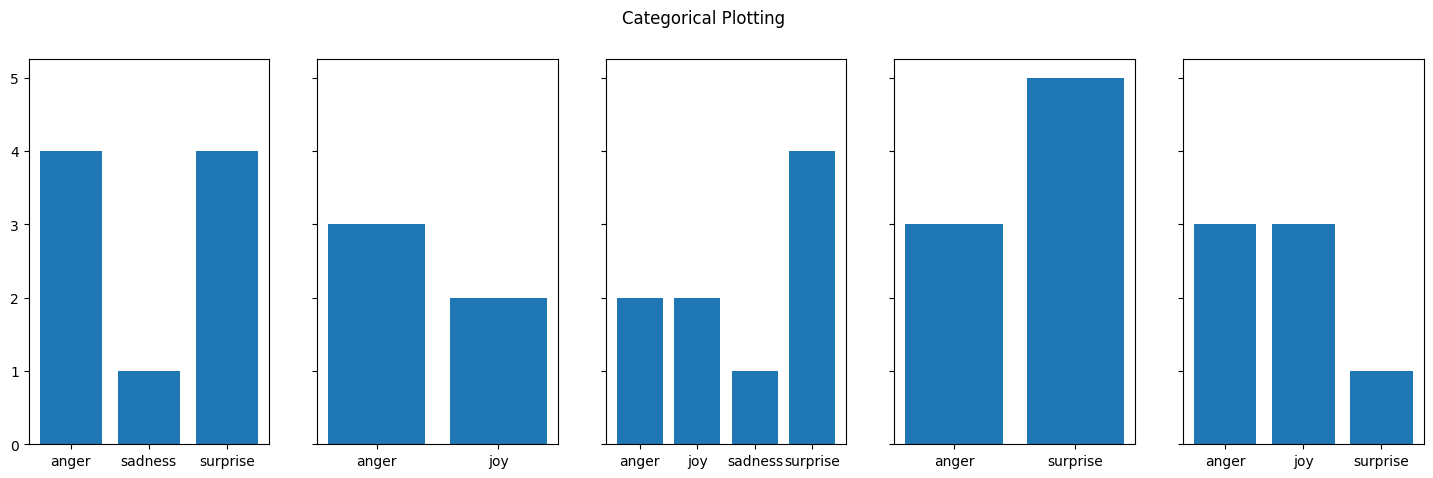

In [200]:
fig, axs = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
axs[0].bar(list(first.keys()), list(first.values()))
axs[1].bar(list(second.keys()), list(second.values()))
axs[2].bar(list(third.keys()), list(third.values()))
axs[3].bar(list(fourth.keys()), list(fourth.values()))
axs[4].bar(list(fifth.keys()), list(fifth.values()))
fig.suptitle('Categorical Plotting')

In [ ]:
# Pie-chart sulle emozioni in generale di Will durante il film

In [238]:
conv_lines = open('movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n')

In [239]:
# Prendo tutte le conversazioni del film

WILL_HUNTING_MOVIE_ID = ' m373 '

conversations = []

for conversation in conv_lines:
    try:
        if conversation.split('+++$+++')[2] == WILL_HUNTING_MOVIE_ID :
            conversations.append(conversation)
    except:
        pass

In [240]:
# Prendo tutte le utterances del film

from collections import defaultdict

movie_lines = defaultdict(lambda: "")

for line in lines:
    try:
        line_elements = line.split('+++$+++')
        line_id, character_id, movie_id, text = line_elements[0], line_elements[1], line_elements[2], line_elements[4] 
        if movie_id == WILL_HUNTING_MOVIE_ID:
            line_id = line_id.replace(' ', '')
            movie_lines[line_id] = (character_id.replace(' ', ''), text)
    except:
        pass

In [271]:
# Filtro le utterance prendendo solo quelle dove WILL è il primo o il secondo 
# personaggio coinvolto nella conversazione

WILL_CHARACTER_ID = ' u5621 ' 

will_utterances = []

for conversation in conversations:
    elements = conversation.split('+++$+++')
    first_character_id, second_character_id, lines_id = elements[0], elements[1], elements[3]
    
    if first_character_id == WILL_CHARACTER_ID or second_character_id == WILL_CHARACTER_ID:
        lines_id = lines_id.replace('[', '')
        lines_id = lines_id.replace(']', '')
        lines_id = lines_id.replace("'", '')
        lines_id = lines_id.replace(" ", '')
        lines_id = lines_id.split(',')
        
        for line in lines_id:
            will_utterances.append(line)
    

In [276]:
for index in range(0, len(will_utterances)):
    line_id = will_utterances[index]
    will_utterances[index] = movie_lines[line_id][1]

In [277]:
will_utterances

[' Chuckie, what the fuck happened?',
 " Okay. He's driving along and this fuckin' cat jumps in front of his car, and so he hits this cat--",
 ' Yeah, so he\'s like "Check the front of my truck, I can prove I hit it \'cause there\'s probably some blood or something"--',
 ' --or a tail--',
 " Stop brushin' me back!",
 ' Stop crowdin the plate!',
 " Casey's bouncin' at a bar up Harvard. We should go there sometime.",
 ' What are we gonna do up there?',
 " I don't know, we'll fuck up some smart kids.  You'd prob'ly fit right in.",
 ' Fuck you.',
 " She's sharp as a marble.",
 ' We\'re not goin\'.  I don\'t even like "Kelly\'s."',
 " She didn't do it again did she?",
 ' Jesus Christ. Not even close.',
 " Jesus, that's really bad, did anyone even order a Flyin' Fish?",
 " No, and we got four of 'em.",
 ' What do we got?',
 " I don't know yet.",
 " Hey, thanks for comin' out.",
 " Yeah, you're all invited over to Morgan's house for a complementary fish sandwhich.",
 " When's the arraignment?

In [278]:
for index in range(0, len(will_utterances)): 
    utterance_to_predict = preprocess_data(will_utterances[index])
    input_ids, att_masks = process_data([utterance_to_predict])
    output = new_model(input_ids = input_ids, attention_mask=att_masks)
    prediction = np.argmax(output.logits.cpu().detach().numpy(),axis=-1)
    confidence = torch.max(softmax(output.logits, dim=1))
    
    if confidence > 0.70:
        will_utterances[index] = emotions_dictionary_inverted[prediction[0]]
    else:
        will_utterances[index] = "NEUTRAL"

In [280]:
will_utterances = [x for x in will_utterances if x != 'NEUTRAL']

In [284]:
will_utterance_df = pandas.DataFrame(will_utterances, columns=['emotion'])


In [285]:
will_utterances

,emotion
0,anger
1,anger
2,surprise
3,anger
4,anger
...,...
298,surprise
299,anger
300,sadness
301,joy


([<matplotlib.patches.Wedge at 0x7f89581b5760>,
 [Text(0.061993448660020434, 1.098251707179751, 'Anger'),
  Text(-0.6678787246083696, -0.8740354736596782, 'Surprise'),
  Text(0.76199684551999, -0.7933226376560704, 'Joy'),
  Text(1.0759623797217406, -0.22870277091353572, 'Sadness')],
 [Text(0.03381460836001114, 0.5990463857344096, '48.2%'),
  Text(-0.3642974861500197, -0.476746621996188, '32.8%'),
  Text(0.4156346430109036, -0.4327214387214929, '12.3%'),
  Text(0.5868885707573129, -0.12474696595283766, '6.7%')])

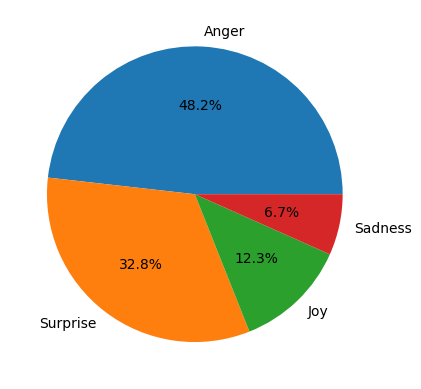

In [287]:
labels = 'Anger', 'Surprise', 'Joy', 'Sadness'
sizes = (will_utterance_df.value_counts().tolist())[1:]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')